# **📘 1. Import Libraries**

In [250]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# **📂 2. Load the Dataset**

In [251]:
df = pd.read_csv('insurance.csv')

# **🔍 3. Initial Data Exploration**

In [252]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [254]:
df.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [255]:
df.describe(include='number')

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


# **🧹 4. Data Cleaning**

In [256]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [257]:
duplicate_rows_df = df[df.duplicated()]
print("Number of duplicate rows:", duplicate_rows_df.shape[0])
duplicate_rows_df

Number of duplicate rows: 1


,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [258]:
df.drop_duplicates(inplace=True)
print("Number of duplicate rows:", df[df.duplicated()].shape[0])

Number of duplicate rows: 0


# **📊 5. Exploratory Data Analysis (EDA)**

In [259]:
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_columns

Index(['age', 'bmi', 'children', 'charges'], dtype='object')

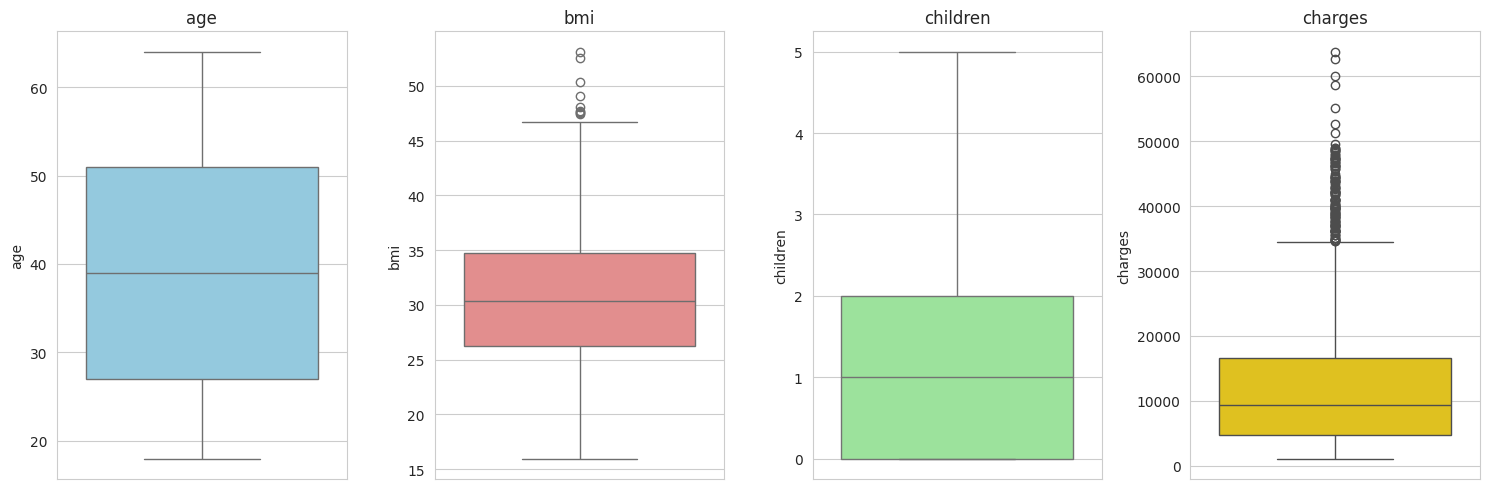

In [260]:
fig, axes = plt.subplots(1, len(numerical_columns), figsize=(15, 5))

colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

for i, col in enumerate(numerical_columns):
    sns.boxplot(ax=axes[i], y=df[col], color=colors[i % len(colors)])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [261]:
def calculate_outlier_percentage(df):
    outlier_percentages = {}

    for col in df.select_dtypes(include=['number']).columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        count_upper = (df[col] > upper_bound).sum()
        count_lower = (df[col] < lower_bound).sum()
        outlier_percentage = round((count_upper + count_lower) / df.shape[0] * 100, 2)

        outlier_percentages[col] = outlier_percentage

    return outlier_percentages

outlier_percentages = calculate_outlier_percentage(df)
for col, percentage in outlier_percentages.items():
    print(f"{col}: {percentage}% outliers")


age: 0.0% outliers
bmi: 0.67% outliers
children: 0.0% outliers
charges: 10.4% outliers


In [262]:
def drop_outliers(df, column):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    if not pd.api.types.is_numeric_dtype(df[column]):
        raise TypeError(f"Column '{column}' is not numeric.")

    df_clean = df.copy()

    q1 = df_clean[column].quantile(0.25)
    q3 = df_clean[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_clean = df_clean[(df_clean[column] >= lower_bound) & (df_clean[column] <= upper_bound)]

    return df_clean

new_df = drop_outliers(df,'bmi')

print(f"Original shape: {df.shape}\nNew shape: {new_df.shape}")


Original shape: (1337, 7)
New shape: (1328, 7)


<Figure size 1000x600 with 0 Axes>

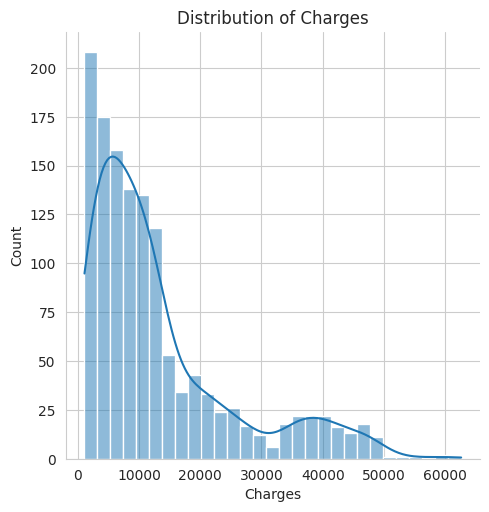

In [263]:
plt.figure(figsize=(10, 6))
sns.set_style('whitegrid')
sns.displot(new_df['charges'], kde=True)
plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.show()

This distribution is right-skewed. To make it closer to normal we can apply natural log

<Figure size 1000x600 with 0 Axes>

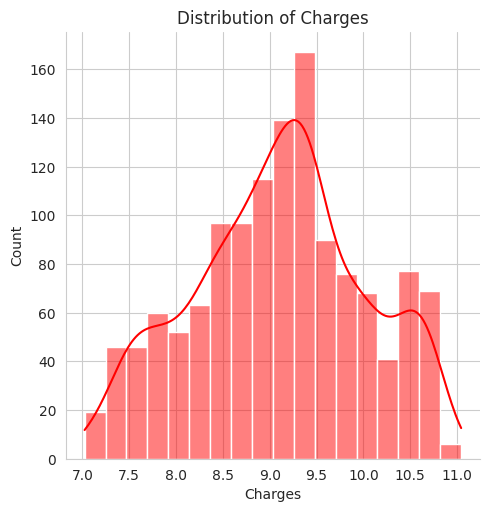

In [264]:
plt.figure(figsize=(10, 6))
sns.displot(np.log(new_df['charges']), kde=True,color='red')
plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.show()

Let's see the distribution of charges across the 4 regions we have

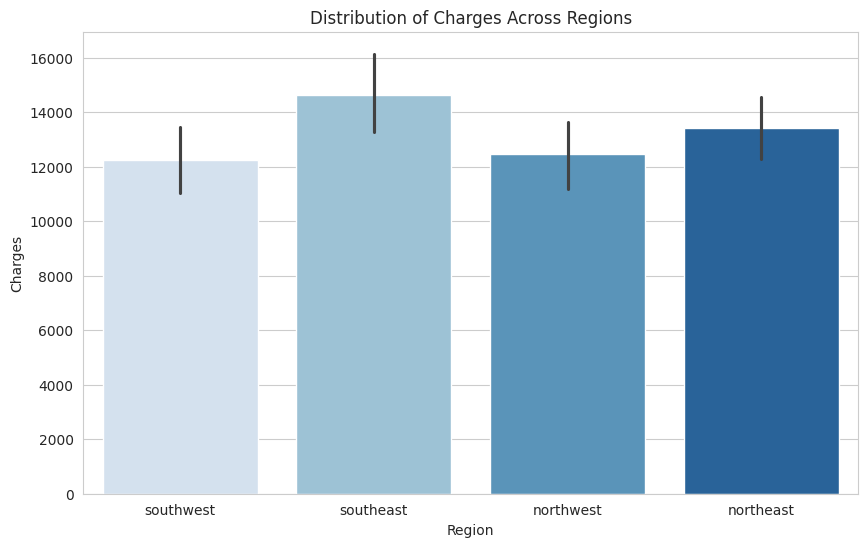

In [265]:
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='charges', data=new_df,palette='Blues')
plt.title('Distribution of Charges Across Regions')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.show()

Looks like the Southeast has the highest medical charges overall, while the Southwest has the lowest. But when you factor in things like gender, whether someone smokes, and if they have kids, the picture changes a bit depending on the region.

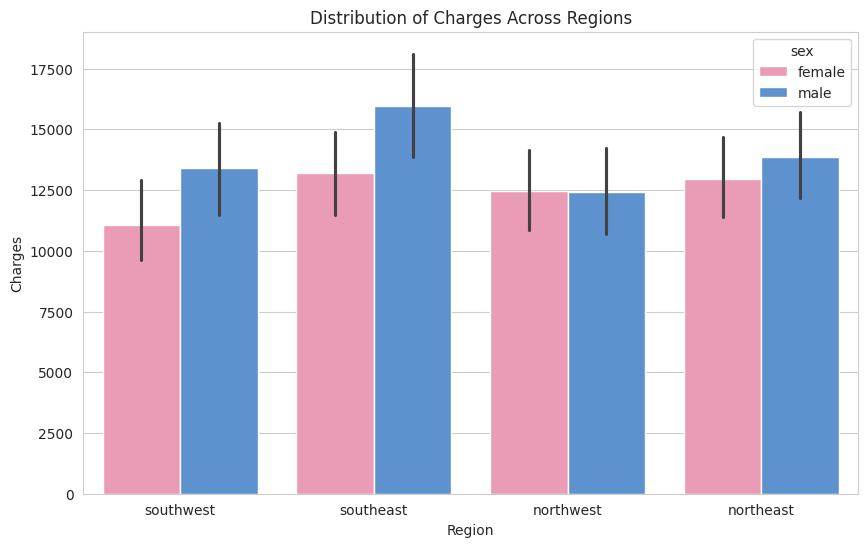

In [266]:
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='charges', hue='sex', data=new_df,palette={'male': '#4A90E2', 'female': '#F78FB3'})
plt.title('Distribution of Charges Across Regions')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.show()

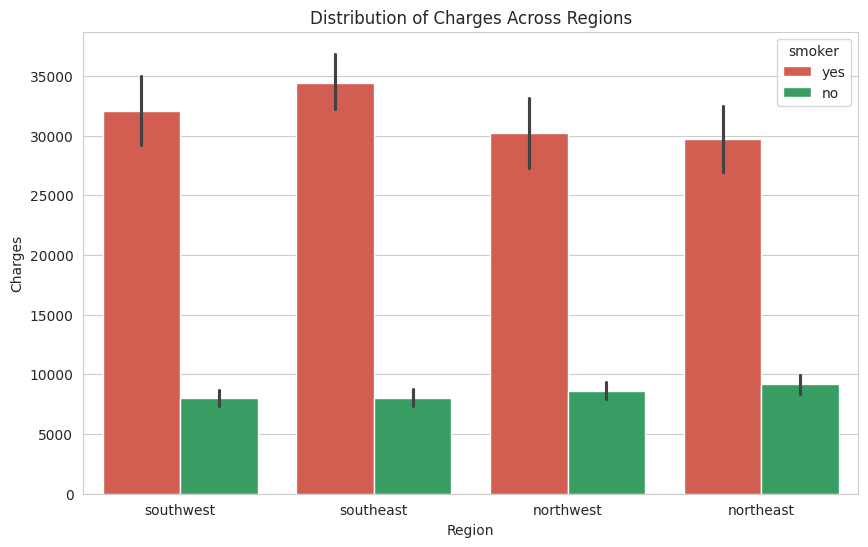

In [267]:
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='charges', hue='smoker', data=new_df,palette={'yes': '#E74C3C', 'no': '#27AE60'})
plt.title('Distribution of Charges Across Regions')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.show()

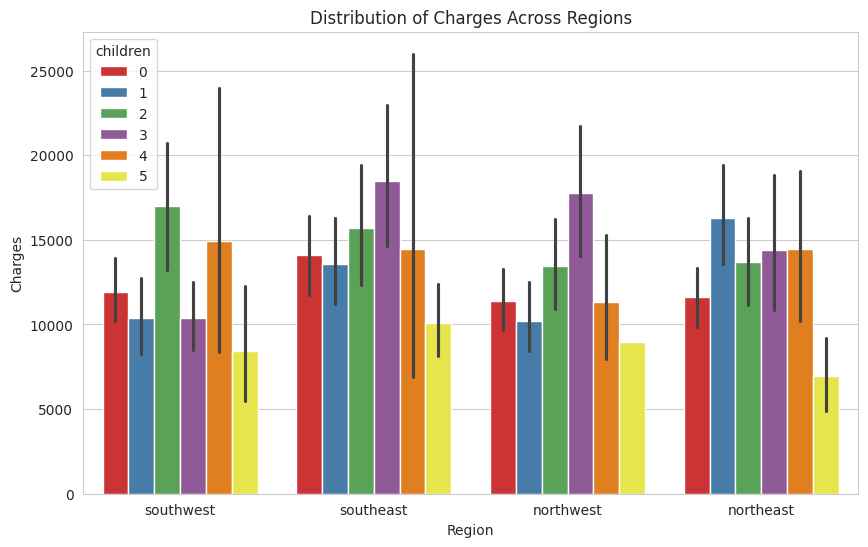

In [268]:
plt.figure(figsize=(10, 6))
sns.barplot(x='region', y='charges', hue='children', data=new_df,palette='Set1')
plt.title('Distribution of Charges Across Regions')
plt.xlabel('Region')
plt.ylabel('Charges')
plt.show()

The barplots show that smoking continues to drive the highest medical charges in the Southeast, while the Northeast sees the lowest. Interestingly, smoking appears to be more common in the Southwest than in the Northeast. However, when looking at gender, individuals in the Northeast tend to face higher charges than those in the Southwest and Northwest. Additionally, having children is generally associated with higher overall medical expenses

Now let’s take a look at how smoking affects medical costs when we also consider things like age, BMI, and whether someone has kids

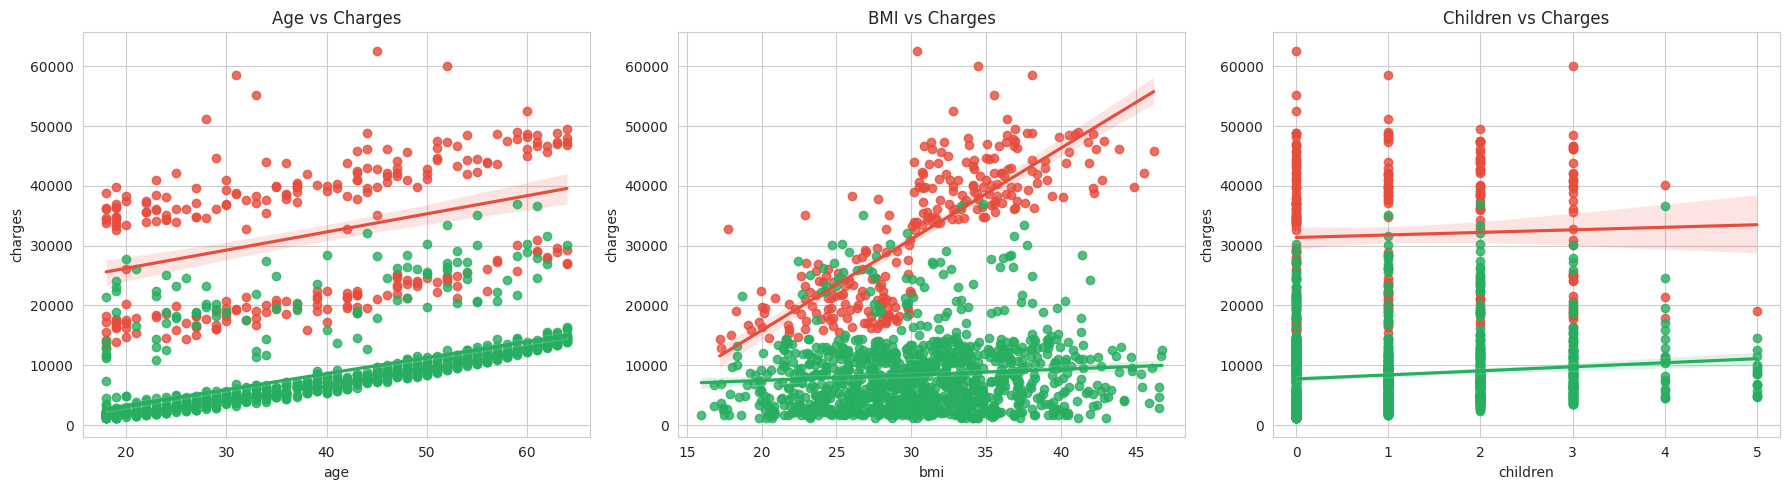

In [269]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age vs Charges
sns.regplot(x='age', y='charges', data=new_df[new_df['smoker'] == 'yes'], ax=axes[0],
            scatter_kws={'color': '#E74C3C'}, line_kws={'color': '#E74C3C'})
sns.regplot(x='age', y='charges', data=new_df[new_df['smoker'] == 'no'], ax=axes[0],
            scatter_kws={'color': '#27AE60'}, line_kws={'color': '#27AE60'})
axes[0].set_title('Age vs Charges')

# BMI vs Charges
sns.regplot(x='bmi', y='charges', data=new_df[new_df['smoker'] == 'yes'], ax=axes[1],
            scatter_kws={'color': '#E74C3C'}, line_kws={'color': '#E74C3C'})
sns.regplot(x='bmi', y='charges', data=new_df[new_df['smoker'] == 'no'], ax=axes[1],
            scatter_kws={'color': '#27AE60'}, line_kws={'color': '#27AE60'})
axes[1].set_title('BMI vs Charges')

# Children vs Charges
sns.regplot(x='children', y='charges', data=new_df[new_df['smoker'] == 'yes'], ax=axes[2],
            scatter_kws={'color': '#E74C3C'}, line_kws={'color': '#E74C3C'})
sns.regplot(x='children', y='charges', data=new_df[new_df['smoker'] == 'no'], ax=axes[2],
            scatter_kws={'color': '#27AE60'}, line_kws={'color': '#27AE60'})
axes[2].set_title('Children vs Charges')

plt.tight_layout()
plt.show()


Smoking has a significant impact on medical insurance charges, with noticeable effects also seen from BMI and age. Interestingly, individuals with children tend to smoke less overall

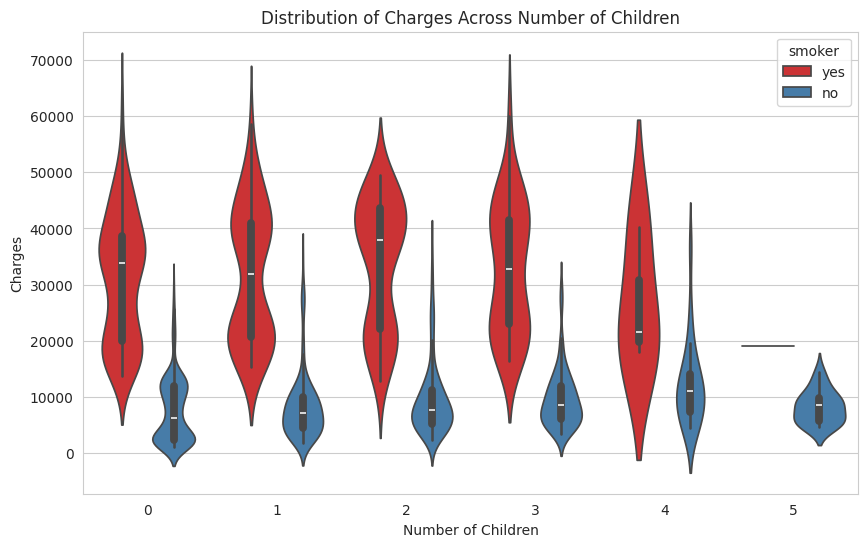

In [270]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='children', y='charges', data=new_df, palette='Set1',hue='smoker')
plt.title('Distribution of Charges Across Number of Children')
plt.xlabel('Number of Children')
plt.ylabel('Charges')
plt.show()

# **⚙️ 6. Feature Engineering & Encoding**

In [271]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

x = new_df.drop('charges', axis=1)
y = new_df['charges']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [272]:
one = OneHotEncoder(drop='first')
one.fit(X_train[['sex', 'smoker', 'region']])

OneHotEncoder(drop='first')

In [273]:
temp = one.transform(X_train[['sex', 'smoker', 'region']])

In [274]:
X_train.drop(['sex', 'smoker', 'region'], axis=1, inplace=True)
X_train

,age,bmi,children
414,19,35.15,0
171,49,30.30,0
947,37,34.20,1
1013,48,32.30,1
210,20,33.00,1
...,...,...,...
1104,37,29.80,0
1139,19,32.49,0
1303,43,27.80,0
867,57,43.70,1


In [275]:
feature_names = one.get_feature_names_out()
feature_names

array(['sex_male', 'smoker_yes', 'region_northwest', 'region_southeast',
       'region_southwest'], dtype=object)

In [276]:
X_train[feature_names] = temp.toarray()
X_train

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
414,19,35.15,0,0.0,0.0,1.0,0.0,0.0
171,49,30.30,0,1.0,0.0,0.0,0.0,1.0
947,37,34.20,1,1.0,1.0,0.0,0.0,0.0
1013,48,32.30,1,1.0,0.0,1.0,0.0,0.0
210,20,33.00,1,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
1104,37,29.80,0,1.0,0.0,0.0,0.0,1.0
1139,19,32.49,0,0.0,1.0,1.0,0.0,0.0
1303,43,27.80,0,1.0,1.0,0.0,0.0,1.0
867,57,43.70,1,1.0,0.0,0.0,0.0,1.0


In [277]:
temp = one.transform(X_test[['sex', 'smoker', 'region']])
X_test.drop(['sex', 'smoker', 'region'], axis=1, inplace=True)
feature_names = one.get_feature_names_out()
X_test[feature_names] = temp.toarray()
X_test

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
1210,36,30.875,1,1.0,0.0,1.0,0.0,0.0
115,60,28.595,0,1.0,0.0,0.0,0.0,0.0
986,43,30.115,3,1.0,0.0,1.0,0.0,0.0
176,38,27.835,2,1.0,0.0,1.0,0.0,0.0
63,28,25.935,1,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
1153,35,35.815,1,0.0,0.0,1.0,0.0,0.0
556,46,33.440,1,1.0,0.0,0.0,0.0,0.0
1206,59,34.800,2,0.0,0.0,0.0,0.0,1.0
584,19,20.700,0,1.0,0.0,0.0,0.0,1.0


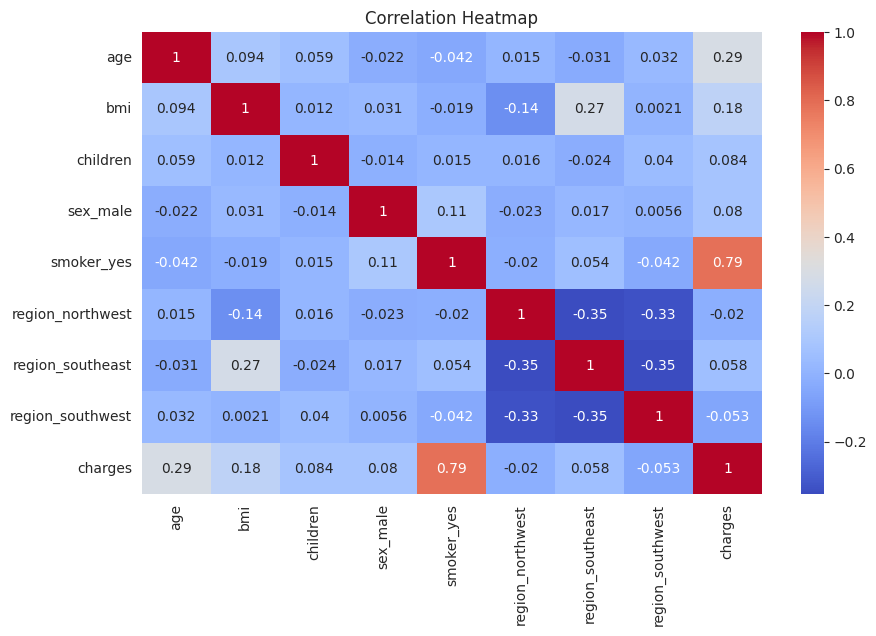

In [278]:
X_all = pd.concat([X_train, y_train], axis=1)
plt.figure(figsize=(10, 6))
sns.heatmap(X_all.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# **📈 7. Modeling**

**Linear Regression**

In [279]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [280]:
y_pred = lr.predict(X_train)
print(f"R2 Score: {r2_score(y_train, y_pred)}")
print(f'MAE: {mean_absolute_error(y_train, y_pred)}')
print(f'MSE: {mean_squared_error(y_train, y_pred)}')

R2 Score: 0.7506633054306888
MAE: 4164.486702571786
MSE: 36163958.09757664


In [281]:
y_pred = lr.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred)}")
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')

R2 Score: 0.744849834054797
MAE: 4125.942676536799
MSE: 35465549.24040006


The model performance metrics might be affected by several factors:
- Data skewness: The distribution of the target or features may be skewed, impacting model accuracy.
- Feature scaling: Some features might need scaling to ensure the model treats all inputs appropriately.
- Binning numerical features: Converting continuous variables into bins could help capture non-linear relationships.

**Log Transformation**

In [282]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [283]:
lr_log = LinearRegression()
lr_log.fit(X_train, y_train_log)

LinearRegression()

In [284]:
y_pred = lr_log.predict(X_train)
print(f"R2 Score: {r2_score(y_train_log, y_pred)}")
print(f'MAE: {mean_absolute_error(y_train_log, y_pred)}')
print(f'MSE: {mean_squared_error(y_train_log, y_pred)}')

R2 Score: 0.7727118105601605
MAE: 0.28105775497244534
MSE: 0.1943149706673642


In [285]:
y_pred_test = lr_log.predict(X_test)
print(f"R2 Score: {r2_score(y_test_log, y_pred_test)}")
print(f'MAE: {mean_absolute_error(y_test_log, y_pred_test)}')
print(f'MSE: {mean_squared_error(y_test_log, y_pred_test)}')

R2 Score: 0.7368965158349827
MAE: 0.26635217243418646
MSE: 0.20232031175964718


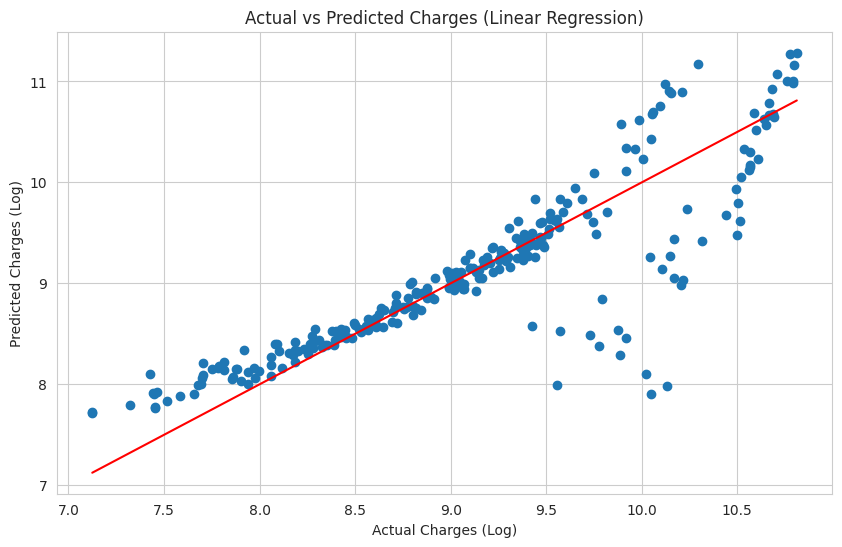

In [286]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_log, y_pred_test)
plt.xlabel("Actual Charges (Log)")
plt.ylabel("Predicted Charges (Log)")
plt.title("Actual vs Predicted Charges (Linear Regression)")
plt.plot([min(y_test_log), max(y_test_log)], [min(y_test_log), max(y_test_log)], color='red')
plt.show()

In [287]:
df_lr = pd.DataFrame({'Actual': np.exp(y_test_log), 'Predicted': np.exp(y_pred_test)})
df_lr

,Actual,Predicted
1210,5373.36425,5627.060398
115,30259.99556,12318.014976
986,8410.04685,8818.888046
176,6455.86265,6436.874872
63,4133.64165,4316.839925
...,...,...
1153,5630.45785,6342.597016
556,8334.58960,9033.641766
1206,36910.60803,15056.241449
584,1242.81600,2264.417484


**Random Forest**

In [288]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100,
                                 criterion='squared_error',
                                 random_state=1,
                                 n_jobs=-1 )

rf_model.fit(X_train, y_train_log)

y_pred_train_rf = rf_model.predict(X_train)

In [289]:
print("Random Forest - Training Set:")
print(f"R2 Score: {r2_score(y_train_log, y_pred_train_rf)}")
print(f"MAE: {mean_absolute_error(y_train_log, y_pred_train_rf)}")
print(f"MSE: {mean_squared_error(y_train_log, y_pred_train_rf)}")

Random Forest - Training Set:
R2 Score: 0.9720315798119672
MAE: 0.07717376822395464
MSE: 0.023910977344859398


In [290]:
y_pred_test_rf = rf_model.predict(X_test)
print("\nRandom Forest - Testing Set:")
print(f"R2 Score: {r2_score(y_test_log, y_pred_test_rf)}")
print(f"MAE: {mean_absolute_error(y_test_log, y_pred_test_rf)}")
print(f"MSE: {mean_squared_error(y_test_log, y_pred_test_rf)}")


Random Forest - Testing Set:
R2 Score: 0.7349632915191668
MAE: 0.23154012792284404
MSE: 0.2038069152058862


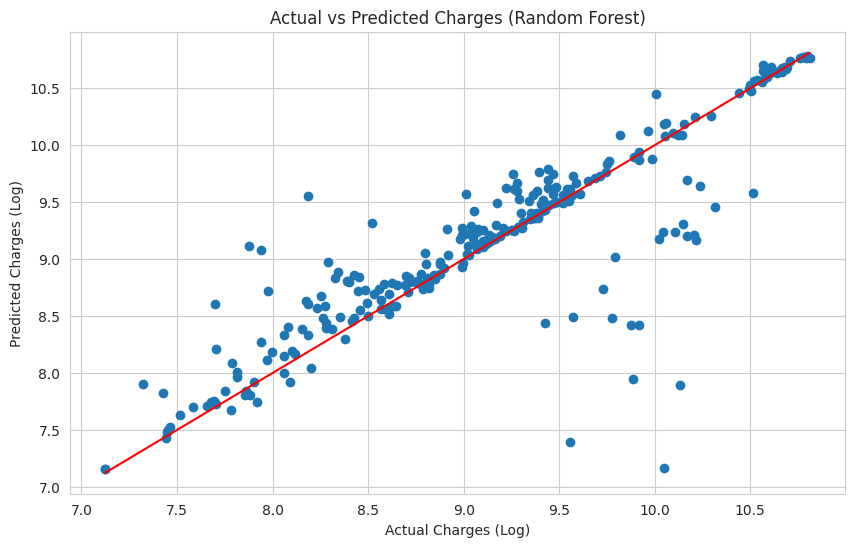

In [291]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_log, y_pred_test_rf)
plt.xlabel("Actual Charges (Log)")
plt.ylabel("Predicted Charges (Log)")
plt.title("Actual vs Predicted Charges (Random Forest)")
plt.plot([min(y_test_log), max(y_test_log)], [min(y_test_log), max(y_test_log)], color='red')
plt.show()

In [292]:
df_rf = pd.DataFrame({'Actual': np.exp(y_test_log), 'Predicted': np.exp(y_pred_test_rf)})
df_rf

,Actual,Predicted
1210,5373.36425,5245.346062
115,30259.99556,12778.583840
986,8410.04685,10868.129748
176,6455.86265,6526.107321
63,4133.64165,6837.827061
...,...,...
1153,5630.45785,5346.303978
556,8334.58960,8390.572270
1206,36910.60803,14518.125412
584,1242.81600,1280.680804


**Residual plot**

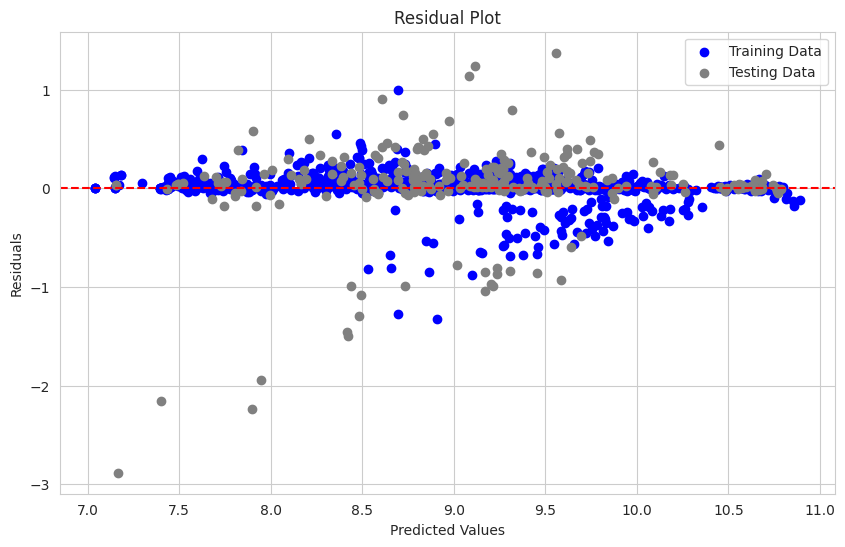

In [293]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_train_rf, y_pred_train_rf - y_train_log, c='blue', label='Training Data')
plt.scatter(y_pred_test_rf, y_pred_test_rf - y_test_log, c='grey', label='Testing Data')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.legend()
plt.show()

# **🛠️ 8. Feature Selection**

In [294]:
importance_list = pd.DataFrame({'Features': X_train.columns, 'Importance': rf_model.feature_importances_})
importance_list = importance_list.sort_values(by='Importance', ascending=False)
importance_list

,Features,Importance
4,smoker_yes,0.443701
0,age,0.378409
1,bmi,0.091111
2,children,0.053575
3,sex_male,0.011651
6,region_southeast,0.008114
5,region_northwest,0.006726
7,region_southwest,0.006714


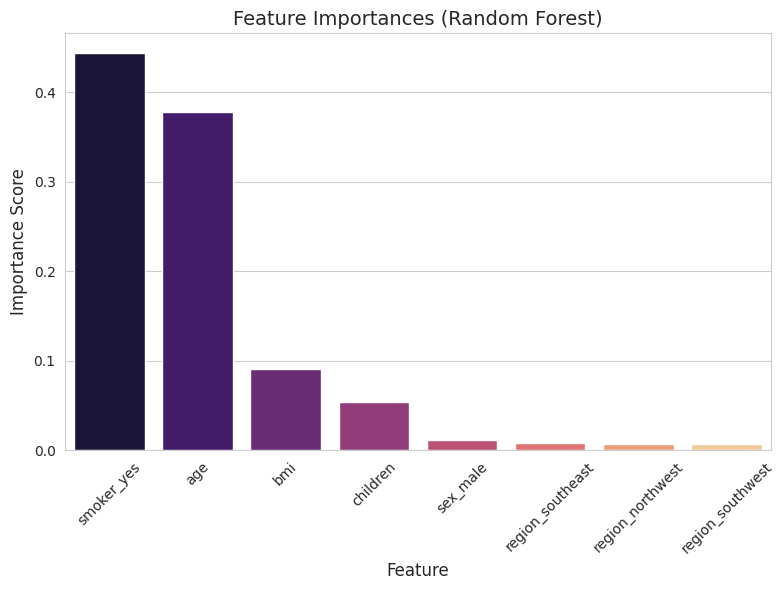

In [295]:
plt.figure(figsize=(8, 6))
sns.barplot(x='Features', y='Importance', data=importance_list, palette='magma',)

plt.title('Feature Importances (Random Forest)', fontsize=14)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Smoking** is the most important factor affecting medical insurance charges

# **💾 9. Saving the Model**

In [296]:
import pickle

with open('rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

with open('one.pkl', 'wb') as file:
    pickle.dump(one, file)